In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

%run ./scripts/util_func.py
%run ./scripts/model_func.py

In [2]:
# import arrays

icp_states = np.load('data/icp_states.npy') # [time, icp_index, icp_x, icp_y, icp_yaw]
wheel_vels = np.load('data/wheel_vels.npy') # [time, icp_index, vel_l, vel_r]


ValueError: Object arrays cannot be loaded when allow_pickle=False

In [3]:
# # test model
# r = 0.3 # wheel radius : meters
# alpha_l = 0.81 # left side friction loss
# alpha_r = 0.84 # right side friction loss
# x_icr = -2.71 # vehicle x_icr
# y_icr_l = 3.0 # left wheels icr in y coordinates
# y_icr_r = -3.85 # right wheels icr in y coordinates
# k = np.array([alpha_l, alpha_r, x_icr, y_icr_l, y_icr_r])

# for i in range(icp_states.shape[0]):
#     Vl = wheel_vels[i, 2]
#     Vr = wheel_vels[i, 3]

#     body_velocity_x, body_velocity_y, body_velocity_phi = extd_diff_drive_asym(Vl, Vr, x_icr, y_icr_l, y_icr_r, alpha_l, alpha_r)
#     print('old_vx : ', r * body_velocity_x)
#     print('old_vy : ', r * body_velocity_y)
#     print('old_vphi : ', r * body_velocity_phi)
    
#     new_vel = icr_diff_drive(wheel_vels[i, 2:], k)
#     print('new_vx : ', new_vel[0])
#     print('new_vy : ', new_vel[1])
#     print('new_vphi : ', new_vel[2])

In [4]:
# compute ext_diff-drive estimates

# params from crv
r = 0.3 # wheel radius : meters
alpha_l = 0.81 # left side friction loss
alpha_r = 0.84 # right side friction loss
x_icr = -2.71 # vehicle x_icr
y_icr_l = 3.0 # left wheels icr in y coordinates
y_icr_r = -3.85 # right wheels icr in y coordinates
k = np.array([alpha_l, alpha_r, x_icr, y_icr_l, y_icr_r])

edd_pose = icp_states[0,2:]

disp = 0.0
propa_mat = np.array([[np.sin(icp_states[0,2]), 0.0, 0.0], 
                      [0.0, np.cos(icp_states[0,3]), 0.0], [0.0, 0.0, 1.0]])

err = np.zeros((int(icp_states[-1, 1]), 3))
for i in range(err.shape[0]):
    err[i,0] = i

dd_vel = np.zeros((icp_states.shape[0], 3))

for i in range(icp_states.shape[0] - 1):
    dt = icp_states[i+1, 0] - icp_states[i, 0]
    disp = comp_disp(icp_states[i+1, 2:3], icp_states[i, 2:3])
    propa_mat[0,0] = np.sin(icp_states[i,2])
    propa_mat[1,1] = np.cos(icp_states[i,3])
    
    edd_pose = edd_pose + propa_mat @ icr_diff_drive(wheel_vels[i, 2:], k) * dt
    
    if icp_states[i+1,1] != icp_states[i,1]:
        err[int(icp_states[i,1]), 1] = disp_err(edd_pose, icp_states[i+1, 2:])
        err[int(icp_states[i,1]), 2] = disp
    dd_pose = icp_states[i+1, 2:]
    
print(err)
    

[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.00000000e+00 2.51590402e-06 1.42270327e-03]
 ...
 [8.71600000e+03 7.93862263e+03 1.02519989e-05]
 [8.71700000e+03 7.93892136e+03 2.42447853e-03]
 [8.71800000e+03 7.93863736e+03 2.23994255e-03]]


In [5]:
def comp_icrs(vl, vr, vx, vy, omega):
    x_icr = -vy / omega
    y_icr_l = (0.3 * vl - vx) / omega
    y_icr_r = (0.3 * vr - vx) / omega
    
    return x_icr, y_icr_l, y_icr_r

index_arr = np.zeros((int(icp_states[-1, 1]), 1))
for i in range(index_arr.shape[0]):
    index_arr[i] = i

vel_l = 0
vel_r = 0

x_icr_arr = np.zeros((int(icp_states[-1, 1]), 1))
y_icr_l_arr = np.zeros((int(icp_states[-1, 1]), 1))
y_icr_r_arr = np.zeros((int(icp_states[-1, 1]), 1))

vel_count = 0

for i in range(icp_states.shape[0] - 1):
    dt += icp_states[i+1, 0] - icp_states[i, 0]
    vel_count += 1    
    
    vel_l += wheel_vels[i, 2]
    vel_r += wheel_vels[i, 3]
    
    if icp_states[i+1,1] != icp_states[i,1] and vel_count > 1:
        icp_vx = (icp_states[i+1, 2] - icp_states[i, 2]) / dt
        icp_vy = (icp_states[i+1, 3] - icp_states[i, 3]) / dt
        icp_omega = (icp_states[i+1, 4] - icp_states[i, 4]) / dt
        
        vel_l = vel_l / vel_count
        vel_r = vel_r / vel_count
        
        x_icr_arr[int(icp_states[i,1])], y_icr_l_arr[int(icp_states[i, 1])], y_icr_r_arr[int(icp_states[i,1])] = comp_icrs(vel_l, vel_r, icp_vx, icp_vy, icp_omega)
        
        vel_l = 0
        vel_r = 0
        dt = 0
        vel_count = 0
    
print(x_icr_arr)


[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 ...
 [ 0.30245595]
 [-0.31762724]
 [ 0.09917918]]


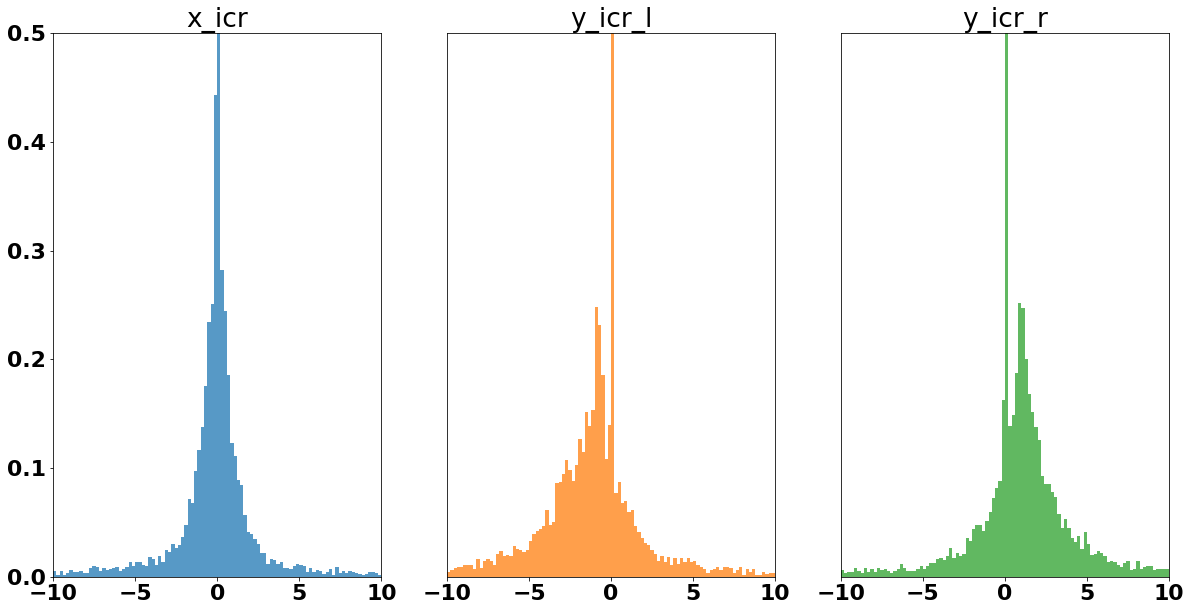

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (20,10))
ax0, ax1, ax2 = axes.flatten()

ax0.hist(x_icr_arr, 100, density=True, facecolor='tab:blue', alpha=0.75, range = [-10.0, 10.0])
ax0.set_title('x_icr')
ax0.set_xlim(-10, 10)
ax0.set_ylim(0, 0.5)

ax1.hist(y_icr_l_arr, 100, density=True, facecolor='tab:orange', alpha=0.75, range = [-10.0, 10.0])
ax1.set_title('y_icr_l')
ax1.set_xlim(-10, 10)
ax1.set_ylim(0, 0.5)
ax1.get_yaxis().set_visible(False)

ax2.hist(y_icr_r_arr, 100, density=True, facecolor='tab:green', alpha=0.75, range = [-10.0, 10.0])
ax2.set_title('y_icr_r')
ax2.set_xlim(-10, 10)
ax2.set_ylim(0, 0.5)
ax2.get_yaxis().set_visible(False)

fig.savefig('./figs/icr_dist.png')
